TODO:
 * precompute $\log|\Sigma_i|$
 * precomute swapped indices for parameter updates

In [1]:
using Distributions
using Seaborn

import CSV
import JLD2
import Base.Filesystem: joinpath

In [2]:
include("src/NGSIM.jl")

Nullable{S}, Base.Nullable{

chmm_em! (generic function with 1 method)

T}) in module Base at nullable.jl:238

In [3]:
K = 8
D = 3

# doesn't line up in format with NGSIM data (specifically, no time/frame aspect)
model = rand_chmm(K, D)
(X, Z, traj_ptr, traj_pairs_full) = rand_trajs(model, 
    T_range=50:500, N_pairs=1_000)

num_trajs = length(traj_ptr) - 1
num_obs = size(X, 2)

 overwritten in module NullableArrays at C:\Users\Hamza El-Saawy\.julia\v0.6\NullableArrays\src\operators.jl:128.


539246

In [4]:
# make fake data like NGSIM
r = zeros(num_obs)
c = zeros(num_obs)

T = 0
for (i, (i1, i2)) in enumerate(traj_pairs_full)
    s1 = traj_ptr[i1]
    e1 = traj_ptr[i1+1]-1
    
    s2 = traj_ptr[i2]
    e2 = traj_ptr[i2+1]-1
    
    @assert (e2-s2) == (e1-s1)
    dT = e2 - s2 + 1
    
    r[s1:e1] = T+(1:dT)
    r[s2:e2] = T+(1:dT)
    T += dT
    
    i = sub2ind((2, num_trajs), 1, i)
    c[s1:e1] = i
    c[s2:e2] = i+1
end

S = sparse(r, c, X[1,:])

@assert all(S.colptr .== traj_ptr)

num_pairs = round(Int, length(traj_pairs_full) / 4)
pairs = zeros(Int, 4, num_pairs)
for (i, ind) in enumerate(randperm(length(traj_pairs_full))[1:num_pairs])
    c1, c2 = traj_pairs_full[ind]
    pairs[1:2, i] = [c1, c2]
    pairs[3, i] = S.rowval[traj_ptr[c1]] + rand(1:10)
    pairs[4, i] = S.rowval[traj_ptr[c1+1]-1] - rand(1:10)
end

## EM

In [5]:
curr = chmm_from_data(X, K)
suff = ChmmSuffStats(curr)
;

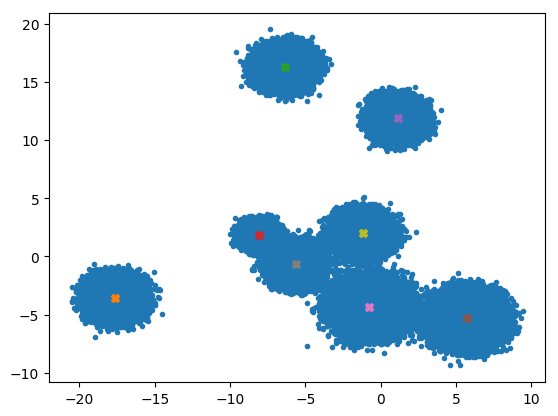

In [6]:
plot(X[1, :], X[2, :], ".")
for i in 1:K
    plot(curr.μs[i][1],curr.μs[i][2], "X")
end

In [ ]:
(curr, log_like_hist) = chmm_em!(S, X, pairs, K, curr, suff; N_iters=20, print_every=1)
;

iteration      1:  -

In [ ]:
plot(X[1, :], X[2, :], ".")
for i in 1:K
    plot(curr.μs[i][1],curr.μs[i][2], "X")
end

In [ ]:
plot(log_like_hist, ".")

# Analysis

In [133]:
true_to_est_lut = empty(Int, K)
for i in 1:K
    m = model.μs[i]
    r = map(mm -> norm(m .- mm), curr.μs)
    true_to_est_lut[i] = indmin(r)
end

In [134]:
hcat([model.μs[i] .- curr.μs[true_to_est_lut[i]] for i in 1:K] ...)

3×8 Array{Float64,2}:
 -0.00259773   1.0915    -1.17078   …  -0.00185141    0.000687139
  0.000367165  0.918668  -0.979448     -0.00126568   -0.00212541 
 -0.00104242   0.158684  -0.169696      0.000543807  -0.00178681 

In [135]:
P_true = copy(model.P)
P_hat = copy( curr.P[true_to_est_lut, true_to_est_lut, true_to_est_lut] )
(mean(P_true .- P_hat), std(P_true .- P_hat))

(-0.001637146389604475, 0.10212816771729014)

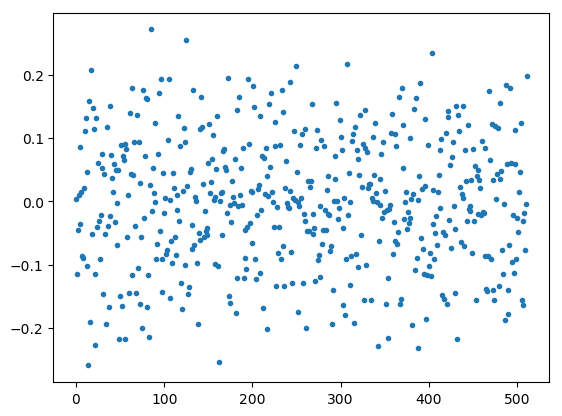

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000028F89B38>

In [136]:
plot(vec(P_true .- P_hat), ".")

In [137]:
p0_true = copy(model.π0)
p0_hat = copy( curr.π0[true_to_est_lut] )
(mean(p0_true .- p0_hat), std(p0_true .- p0_hat))

(0.013871179798408571, 0.14383302753909002)

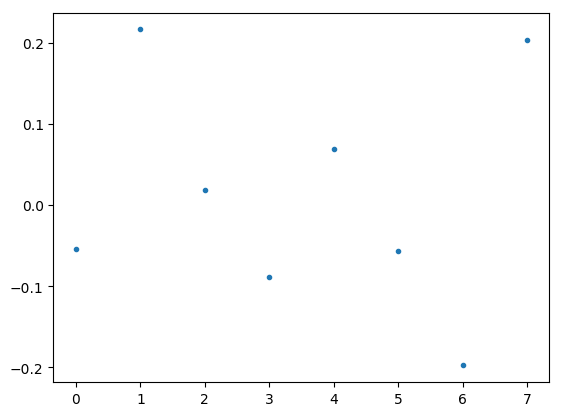

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000028FE1390>

In [138]:
plot(vec(p0_true .- p0_hat), ".")

In [141]:
errs = [model.Σs[i] .- curr.Σs[true_to_est_lut[i]] for i in 1:K]
[map(mean, errs) map(std, errs)]

8×2 Array{Float64,2}:
 -0.284251   0.426377
 -0.135193   0.20279 
 -0.093362   0.140043
 -0.216918   0.325377
 -0.20574    0.30861 
 -0.150884   0.226326
 -0.0628253  0.094238
 -0.106907   0.160361